### Branch-and-Price Framework

- Features:
    - Python + Gurobi/etc.
    - Self-defined PricingProblem/BranchingRules
    - A demo of GraphColoringProblem
    
- TODOs: 
    - Unify format
    - Add Cut
    - Parallel
    - Node Visiting Priority

#### Imports

In [34]:
# from __future__ import annotations
from typing import List, Tuple, Dict, Type, Set
import numpy as np
import random
from gurobipy import *
import queue
import time
from abc import ABC, abstractmethod
from timeit import default_timer as timer
from enum import Enum
from collections import Counter
import networkx as nx

#### debug utils

In [35]:
# debug utils
from importlib import reload
import logging
import inspect


def log(message, logger=logging.error):
    func = inspect.currentframe().f_back.f_code
    txt = "{}\t[{}, {}, {}]".format(message,
        func.co_name, 
        func.co_filename, 
        func.co_firstlineno)
    logging.debug(txt)
    print('@@@@@', txt)
    
    
def _printLP(m):
    m.write('tmp.lp')
    f = open('tmp.lp', 'r')
    for l in f.readlines():
        print(l)
    print('====================')
    

def isInt(num):
    return (float(num)).is_integer()


#### display flags

In [36]:
# display flags
DEBUG = True
OUTPUT_LP = True
GRB_OUTPUT = False

reload(logging)
logging.basicConfig(level=logging.DEBUG if DEBUG else logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%I:%M:%S')
printGRBLP = lambda m: _printLP(m) if OUTPUT_LP else False

#### Consts

In [37]:
MAX_IT = 100000
MAX = 1e6
EPS = 1e-5

In [38]:
class VarType(Enum):
    REAL = 0
    BINARY = 1
    INTEGER = 2
    

class ModelSense(Enum):
    MAX = 1
    MIN = -1
    
    
class NodeStatus(Enum):
    INFEASIBLE = 'inf'
    WORSE_BOUND = 'boundWorse' 
    WORSE_INT = 'intWorse'
    LOCAL_OPT = 'localOpt'
    GLOBAL_OPT = 'globalOpt'
    NOT_SOLVED = 'unsolved'
    FRAC = 'frac'


#### abstract model

initRowsWithRHS(rowNames:List[str], bs: List[int])

addOneColByRowName(self, name:str, vtype:VarType, objCoe:float, rowNames:List[str], rowCoes:List[float], ub:float, instant:bool)

setObjByColNames(varNames:List[str], objCoes:List[float])


In [39]:
# abstract model
# min obj
# s.t. Ax <= b; x >= 0
class AbstractModel(ABC):
    def __init__(self, name, sense:Type[ModelSense]):
        self.name = name
        self.counter = Counter()
        self.name2col = {}
        self.name2row = {}
        self.modelSense = sense
        #self.count_namer = lambda name,count: "{}_{}".format(name, count)
        self.count_namer = lambda name,count: name
    
        
    def modify(col=False, row=False, add=False, remove=False, update=False):
        def modify_key(func):
            def foo(*args, **kwargs):
                if col == row or (add == False and remove == False and update == False):
                    print( col == row , (add == False and remove == False and update == False) , args, kwargs)
                    raise Exception("Decorator Error")
                else:
                    self = args[0]
                    key = ''
                    if len(args) >= 2:
                        key = args[1]
                    elif 'colName' in kwargs:
                        key = kwargs['colName']
                    elif 'rowName' in kwargs:
                        key = kwargs['rowName']
                    else:
                        raise Exception('no name')
#                     print(key, '()', update, add, remove, self.name)
                    name2obj = self.name2col if col else self.name2row
                    if add:
                        res = func(*args, **kwargs)
                        k = (key, col, row)
                        self.counter[k] += 1
                        
                        if self.counter[k] > 1:
                            key = self.count_namer(key, self.counter[k])
                            log("Name Already Exists: {}".format(key))
                        name2obj[key] = res
                        return key
                    else:
                        if key in name2obj:
                            func(*args, **kwargs)
                            if remove:
                                name2obj.pop(key)
                                k = (key, col, row)
                                self.counter[k]  -= 1
                        else:
                            log("Name Does Not Exist: {}".format(key))
            return foo
        return modify_key
    
    
    @abstractmethod
    def update_model(self):
        pass
    

#     @modify(row=True, add=True)
    @abstractmethod
    def addEmptyRowWithRHS(self, rowName:str, rhs:float, instant:bool):
        pass
        
#     @modify(col=True, add=True)
    @abstractmethod
    def addOneColByRowName(self, colName:str, vtype:VarType, objCoe:float, rowNames:List[str], rowCoes:List[float], ub:float, instant:bool):
        pass
    
#     @modify(row=True, add=True)
    @abstractmethod
    def addOneRowByColName(self, rowName:str, lhVarNames:List[str], lhCoes:List[float], rhs:float, instant:bool):
         pass
        
#     @modify(col=True, remove=True)        
    @abstractmethod
    def removeColByName(self, colName:str, instant:bool):
        pass
        
#     @modify(row=True, remove=True)        
    @abstractmethod
    def removeOneRowByName(self, rowName:str, instant:bool):
        pass
        
        
#     @modify(col=True, update=True)    
    @abstractmethod
    def updateOneObjCoeByColName(self, colName:str, objCoe: float, instant:bool):
        pass
    
    
    # Default Bulk Modification, could be overriden by customimzed implementation
    def initRowsWithRHS(self, rowNames:List[str], bs: List[int]):
        for r, b in zip(rowNames, bs):
            self.addEmptyRowWithRHS(r, b, False)
        self.update_model()
        
    
    def removeColsByNames(self, colNames:List[str]):
        for c in colNames:
            self.removeColByName(c, False)
        self.update_model()
            
    
    def removeRowsByNames(self, rowNames:List[str]):
        for r in rowNames:
            self.removeOneRowByName(r, False)    
        self.update_model()
    
    
    def setObjByColNames(self, varNames:List[str], objCoes:List[float]):
        for c, v in zip(objCoes, varNames):
            self.updateOneObjCoeByColName(v, c, False)
        self.update_model()
    # End of Default Bulk Modification
    
    
    
    @abstractmethod
    def optimize(self, timeout:int):
        pass
    
    
    @abstractmethod
    def getIsOptimal(self)->bool:
        pass
    
    
    @abstractmethod
    def getObjVal(self)->float:
        pass
    
    
    @abstractmethod
    def getSol(self)->List[Tuple[str, float]]:
        pass
    
    
    @abstractmethod
    def getCols(self)->List[str]:
        pass
    
    
    @abstractmethod
    def getDualPis(self)->List[Tuple[str,float]]:
        pass
    
    
    @abstractmethod
    def printProgram(self):
        pass

    
    @abstractmethod
    def printSolution(self):
        pass
    
    
    @abstractmethod
    def getRHS(self)->List[Tuple[str, float]]:
        pass
    
    
    def getNonZeroColsSol(self)->List[Tuple[str, float]]:
        return [(c,v) for c, v in self.getSol() if v > 0]
    
    


#### GurobiModelSolver

In [40]:
# abstract model
# min obj
# s.t. Ax <= b; x >= 0
class GurobiModel(AbstractModel):
    def __init__(self, name="untitled_model", sense=ModelSense.MIN):
        super().__init__(name, sense)
        
        sense = GRB.MAXIMIZE if sense == ModelSense.MAX else GRB.MINIMIZE
        
        self.model = Model(name)
        self.model.setParam("OutputFlag", GRB_OUTPUT)
        self.model.setObjective(0, sense=sense)
        self.ineqSense = GRB.GREATER_EQUAL if self.modelSense == ModelSense.MIN else GRB.LESS_EQUAL
    
    vartype2GRBvtype = dict({VarType.INTEGER: GRB.INTEGER, VarType.REAL: GRB.CONTINUOUS, VarType.BINARY: GRB.BINARY})

    def update_model(self):
        self.model.update()


    @AbstractModel.modify(row=True, add=True)
    def addEmptyRowWithRHS(self, rowName:str, rhs:float, instant=True):
        res = self.model.addConstr(lhs=0, sense=self.ineqSense, rhs=rhs, name=rowName)
        if instant:
            self.update_model()
        return res
        
    
    @AbstractModel.modify(col=True, add=True)
    def addOneColByRowName(self, colName:str, vtype:VarType, objCoe:float, rowNames:List[str], rowCoes:List[float], ub=float('inf'), instant=True):
#         print(self.name2row, rowNames)
        column = Column(rowCoes, [self.name2row[n] for n in rowNames]) if rowNames else None
        ub = GRB.INFINITY if ub==float('inf') else ub
        vtype = GurobiModel.vartype2GRBvtype[vtype]
        res = self.model.addVar(obj=objCoe, vtype=vtype, name=colName, ub=ub, column=column)
        if instant:
            self.update_model()
        return res
    
    
    @AbstractModel.modify(row=True, add=True)
    def addOneRowByColName(self, rowName:str, lhVarNames:List[str], lhCoes:List[float], rhs:float, instant=True):
        res = self.model.addConstr(lhs=quicksum( c * self.name2col[n] for c, n in zip(lhCoes, lhVarNames)), sense=self.ineqSense, rhs=rhs, name=rowName)
        if instant:
            self.update_model()
        return res
        
        
    @AbstractModel.modify(col=True, remove=True)
    def removeColByName(self, colName:str, instant=True):
        res = self.model.remove(self.name2col[colName])
        if instant:
            self.update_model()
        return res

        
    @AbstractModel.modify(row=True, remove=True)
    def removeOneRowByName(self, rowName:str, instant=True):
        res = self.model.remove(self.name2row[rowName])
        if instant:
            self.update_model()
        return res


    @AbstractModel.modify(col=True, update=True)
    def updateOneObjCoeByColName(self, colName:str, objCoe: float, instant=True):
        self.name2col[colName].setAttr(GRB.Attr.Obj, objCoe)
        if instant:
            self.update_model()
        

    def optimize(self, timeout=0):
        if timeout > 0:
            self.model.setParam('TimeLimit', timeout)
        self.model.optimize()
        return self.model.Runtime
    
    
    def getIsOptimal(self)->bool:
        return self.model.status == GRB.OPTIMAL
    
    
    def getObjVal(self)->float:
        return self.model.objVal
    
    
    def getSol(self)->List[Tuple[str, float]]:
        return [(c.varName, c.X) for c in self.model.getVars()]
    
    
    def getCols(self)->List[str]:
        return [c.varName for c in self.model.getVars()]
    

    def getDualPis(self)->List[Tuple[str, float]]:
        rows = self.model.getConstrs()
        return [(r.constrName,p) for r,p in zip(rows, self.model.getAttr('Pi',  rows))]
    

    def printProgram(self):
        printGRBLP(self.model)

    
    def printSolution(self):
        if not OUTPUT_LP:
            return 
        if self.getIsOptimal():
            for c, v in self.getSol():
                print('{} = {}'.format(c, v))
        else:
            print('no optimal sol')
    
    
    def getRHS(self)->List[Tuple[str, float]]:
        return [ (r.constrName, r.RHS) for r in self.model.getConstrs() ]

        


In [41]:
# Unit Test of GurobiModel
m =  GurobiModel(name="ModelX", sense=GRB.MINIMIZE)
m.addEmptyRowWithRHS(rowName='row0', rhs=1)

m.initRowsWithRHS(rowNames=['row_a', 'row_b'], bs=[2.1, 2])

m.addOneColByRowName(colName='x', vtype=VarType.REAL, objCoe=0, rowNames=[], rowCoes=[], ub=float('inf'))
m.addOneRowByColName(rowName='row1', lhVarNames=['x'], lhCoes=[1], rhs=5)
m.addOneRowByColName(rowName='row2', lhVarNames=['x'], lhCoes=[3], rhs=2.1)
m.printProgram()

m.removeOneRowByName(rowName='row0')
m.updateOneObjCoeByColName(colName='x',objCoe=2)
m.printProgram()

m.addOneColByRowName(colName='y', vtype=VarType.REAL, objCoe=0, rowNames=['row1', 'row2'], rowCoes=[2.4, 2.2], instant=False)
m.update_model()
m.printProgram()

m.removeColByName(colName='x')
m.printProgram()

m.removeOneRowByName(rowName='row_a')
m.removeOneRowByName(rowName='row_b')
m.optimize()
m.printSolution()
print(m.getObjVal())
print(m.getDualPis())


\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

 

Subject To

 row0: >= 1

 row_a: >= 2.1

 row_b: >= 2

 row1: x >= 5

 row2: 3 x >= 2.1

Bounds

End

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

  2 x

Subject To

 row_a: >= 2.1

 row_b: >= 2

 row1: x >= 5

 row2: 3 x >= 2.1

Bounds

End

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

  2 x

Subject To

 row_a: >= 2.1

 row_b: >= 2

 row1: x + 2.4 y >= 5

 row2: 3 x + 2.2 y >= 2.1

Bounds

End

\ Model ModelX

\ LP format - for model browsing. Use MPS format to capture full model detail.

Minimize

 

Subject To

 row_a: >= 2.1

 row_b: >= 2

 row1: 2.4 y >= 5

 row2: 2.2 y >= 2.1

Bounds

End

y = 2.0833333333333335
0.0
[('row1', -0.0), ('row2', 0.0)]


### abstractBranchAndPrice

#### BnPTreeNode

In [42]:
class BnBTreeNode:
    def __init__(self, nid:int, decision:str, father:int, status:NodeStatus, bound:float, path=[]):
        self.decision = decision
        self.nid = nid
        self.father = father
        self.status = status
        self.bound = bound
        self.children = []
        self.solution = []
        self.path = path
        if father!= None:
            self.path.append(father.nid)
        

    def convert2another(self, node)->Tuple[List[int], List[int]]:
        i = 0
        while i < min(len(node.path), len(self.path)) and node.path[i] == self.path[i]:
            i += 1
        return self.path[i:][::-1], node.path[i:]

#### abstractHelper

In [43]:
class AbstractHelper(ABC):
    def __init__(self, data):
        self.data = data
        
        
    @abstractmethod
    def nameOfCol(self, sth)->str:
        pass
    
    
    @abstractmethod
    def colOfName(self, name:str):
        pass
    
    
    @abstractmethod
    def colCoes(self, sth)->Tuple[List, List[float]]:
        pass
    
    
    @abstractmethod
    def objOfCol(self, sth)->float:
        pass
    
    
    @abstractmethod
    def nameOfRow(self, sth)->str:
        pass
    
    
    @abstractmethod
    def rowOfName(self, name:str):
        pass
    
    
    @abstractmethod  
    def nameOfBranch(self, sth)->str:
        pass
    
    
    @abstractmethod
    def branchOfName(self, name:str):
        pass

#### abstractMaster

In [44]:
class AbstractMaster(ABC):
    def __init__(self, name:str, data, modelClass:Type[AbstractModel], 
                 modelSense, helper:Type[AbstractHelper]):
        
        self.name = name
        self.data = data
        self.model = modelClass(name, modelSense)
        self.helper = helper
        
        self.branch2actions = {}
        
        self.nameOfCol = helper.nameOfCol
        self.colOfName = helper.colOfName
        self.colCoes = helper.colCoes
        self.objOfCol = helper.objOfCol
        self.nameOfRow = helper.nameOfRow
        self.rowOfName = helper.rowOfName
        self.nameOfBranch = helper.nameOfBranch
        self.branchOfName = helper.branchOfName
    
    
    @abstractmethod
    def cutCoes(self, sth)->Tuple[List, List[float], float]:
        pass
    
    
    @abstractmethod
    def provideRHS(self, sth)->float:
        pass
    
    
    @abstractmethod
    def provideInitRows(self)->List:
        pass
    
    
    @abstractmethod
    def provideInitCols(self)->List:
        pass
    
    
    @abstractmethod
    def onBranchPerformed(self, node:Type[BnBTreeNode]):
        pass
    
    
    @abstractmethod
    def onBranchReverted(self, node:Type[BnBTreeNode]):
        pass
    
    # returns list of branch sth
    @abstractmethod
    def branchGenerator(self)->List:
        pass
    
    
    def isIntSol(self):
        for c,v in self.model.getSol():
            if abs(math.ceil(v) - v) + abs(math.floor(v)-v) > EPS:
                return False
        return True
    

    def add_col(self, col):
#         print(col, 'new')
        colName = self.nameOfCol(col)
        rows, colCoes = self.colCoes(col)
        rowNames = [self.nameOfRow(i) for i in rows]
        colObj = self.objOfCol(col)
            
        self.model.addOneColByRowName(colName=colName, vtype=VarType.REAL, 
                                        objCoe=colObj, rowNames=rowNames, rowCoes=colCoes, 
                                        ub=float('inf'), instant=False)
        
    
    def build(self):
        rows = self.provideInitRows()
        rowNames = [self.nameOfRow(r) for r in rows]
        bs = [self.provideRHS(r) for r in rows]
        self.model.initRowsWithRHS(rowNames=rowNames, bs=bs)
        
        for col in self.provideInitCols():
            self.add_col(col)
        
        self.model.update_model()
        
        

#### abstractPricing

In [45]:
class AbstractPricing(ABC):
    def __init__(self, name, data, helper):
        self.name = name
        self.data = data
        self.nameOfCol = helper.nameOfCol
        self.colOfName = helper.colOfName
        self.colCoes = helper.colCoes
        self.objOfCol = helper.objOfCol
        self.nameOfRow = helper.nameOfRow
        self.rowOfName = helper.rowOfName
        self.nameOfBranch = helper.nameOfBranch
        self.branchOfName = helper.branchOfName
        self.helper = helper
        
        self.branch2actions = {}
        
        
    @abstractmethod
    def build(self):
        pass
    
    
    @abstractmethod
    def updateByDual(self, sths:List, duals:List[float]):
        pass
    
    
    # return a col object or None
    @abstractmethod
    def genAColAndReturn(self):
        pass
    
    
    @abstractmethod
    def onBranchPerformed(self, node:Type[BnBTreeNode]):
        pass
    
    
    @abstractmethod
    def onBranchReverted(self, node:Type[BnBTreeNode]):
        pass
    
    @abstractmethod
    def printProgram(self):
        pass
    
    @abstractmethod
    def printSolution(self):
        pass
    

#### B&P

In [67]:
class BnP:
    def __init__(self, name:str, data, modelClass:Type[AbstractModel], 
                masterClass, modelSense: Type[ModelSense], pricingClass, helperClass,
                muteColGened=False, muteBranchBegin=False, muteBranchSolved=False, muteNewBranchAdded=False):
        
        self.muteColGened = muteColGened
        self.muteBranchBegin = muteBranchBegin
        self.muteBranchSolved = muteBranchSolved
        self.muteNewBranchAdded = muteNewBranchAdded
        
        
        self.name = name
        self.data = data
        self.modelSense = modelSense
        self.helper = helperClass(data)
        
        self.master = masterClass(name+"-Master", data, modelClass, modelSense, self.helper)
        self.pricing = pricingClass(name+"-Pricing", data, self.helper)
        self.root = BnBTreeNode(decision='ROOT', nid=0, father=None, status=NodeStatus.NOT_SOLVED, bound=float('inf'), path=[0])
        self.nodes = [self.root]
        self.nodeCount = 0
        self.queue = []
        self.incumbent = float('inf') if self.modelSense == ModelSense.MIN else -float('inf') 
        
        self.best_incumbent = 0
        self.quitEarly = False

        helper = self.helper
        self.nameOfCol = helper.nameOfCol
        self.colOfName = helper.colOfName
        self.colCoes = helper.colCoes
        self.objOfCol = helper.objOfCol
        self.nameOfRow = helper.nameOfRow
        self.rowOfName = helper.rowOfName
        self.nameOfBranch = helper.nameOfBranch
        self.branchOfName = helper.branchOfName
        
        self.numCols = 0


    def newNodeIndex(self)->int:
        self.nodeCount += 1 
        return self.nodeCount


    def performBranch(self, node:Type[BnBTreeNode]):
        res = self.master.onBranchPerformed(node)
        res = self.pricing.onBranchPerformed(node)


    def revertBranch(self, node:Type[BnBTreeNode]):
        self.master.onBranchReverted(node)
        self.pricing.onBranchReverted(node)


    def newBranch(self, decision:str, curNode:Type[BnBTreeNode]):
        for nid in curNode.path:
            if self.nodes[nid].decision == decision:
                return
            
        dup = set()
        for n in self.nodes:
            r = str(sorted([self.nodes[x].decision for x in n.path]))
#             print(r)
            assert r not in dup
            dup.add(r)
            
        node = BnBTreeNode(nid=self.newNodeIndex(), decision=decision, father=curNode, status=NodeStatus.NOT_SOLVED, bound=curNode.bound)
        
        node.path = curNode.path + [node.nid]
        curNode.children.append(node)
        self.nodes.append(node)
        self.queue.append(node)
        self.logNewBranchAdded(decision)


    def gcsolve(self):
        for it in range(MAX_IT):
            if not self.genACol():
                break
            
            if not self.master.model.getIsOptimal():
                log('master not good')
                break

        return self.master.model.getIsOptimal()
    

    def visitANode(self, node:Type[BnBTreeNode], last:Type[BnBTreeNode]):
        toRevert, toPerform = last.convert2another(node)
        self.logBranchBegin(node, toRevert, toPerform)
        
        for b in toRevert:
            self.revertBranch(self.nodes[b])
        for b in toPerform:
            self.performBranch(self.nodes[b])
        

        if self.gcsolve():
            bound = self.master.model.getObjVal() 
            sol = self.master.model.getSol()
            node.bound = bound
                
            if self.modelSense == ModelSense.MIN and bound > self.incumbent or \
                self.modelSense == ModelSense.MAX and bound < self.incumbent :
                
#                 node.bound = bound
                if self.master.isIntSol():
                    node.status = NodeStatus.WORSE_INT
                else:
                    node.ststus = NodeStatus.WORSE_BOUND
            else:
                if self.master.isIntSol():
                    self.incumbent = bound
                    node.bound = bound
                    node.status = NodeStatus.LOCAL_OPT
                    node.solution = sol
                    
                    if bound == self.best_incumbent:
                        self.quitEarly = True
                    
                else:
                    node.status = NodeStatus.FRAC
                    
                    if node.decision == 'ROOT':
                        self.best_incumbent = math.floor(bound) if self.modelSense == ModelSense.MAX else math.ceil(bound)
                    
                    for branch in self.master.branchGenerator():
                        self.newBranch( self.nameOfBranch(branch), node )
        else:
            node.status = NodeStatus.INFEASIBLE
            node.bound = float('inf')
            
        self.logBranchSolved(node)



    def branchAndPrice(self):
        self.master.build()
        self.pricing.build()
        self.queue.append(self.root)
        last = self.root
        while self.queue:
            
            if self.quitEarly:
                break
            
            node = self.queue.pop()
            self.visitANode(node, last)
            last = node
            
            self.numCols = max(self.numCols, len(self.master.model.getCols()))
            
        for l in self.nodes:
            if l.bound == self.incumbent:
                l.status = NodeStatus.GLOBAL_OPT
          

    def genACol(self):
        self.master.model.optimize()
        colAddedFlag = False
        
        if self.master.model.getIsOptimal():
            rows, pis = [], []
            for rowName, pi in self.master.model.getDualPis():
                rows.append(self.rowOfName(rowName))
                pis.append(pi)

            self.pricing.updateByDual(rows, pis)
            newCol = self.pricing.genAColAndReturn()
            
            if not (newCol is None):
                self.master.add_col(newCol)
                colAddedFlag = True

            self.logColGened(rows, pis, newCol)
        
        return colAddedFlag


    def dispMasterSolution(self):
        cols, sol = self.master.getNonZeroColsSol()
        self.dispASolution(cols, sol)
        
    
    def logColGened(self, rows, pis, newCol):
        if self.muteColGened:
            return
        
        print("Pis:" + '; '.join(["[{}]: {} ".format(r,p) for r,p in zip(rows, pis)]))
        if newCol != None:
            print('New Col Generated: ', newCol)        
#             self.pricing.printProgram()
#         self.pricing.printSolution()
    
    
    def logBranchBegin(self, node, toRevert, toPerform):
        if self.muteBranchBegin:
            return
        print('\n\n', ''.join(['-']*64), '\n')
        print('Current Branch Path: ', [self.nodes[nid].decision for nid in node.path], '\n\n')
#         print('nRevert', [self.nodes[nid].decision for nid in toRevert], toRevert)
#         print('nPerform', [self.nodes[nid].decision for nid in toPerform])
#         print('Master Before: ') 
#         self.master.model.printProgram()
        
        
    def logBranchSolved(self, node):
        if self.muteBranchSolved:
            return
        print('\n\n\n')
        print('Master After: ')
        self.master.model.printProgram()
        print('\n\n')
        print("#cols: ",len(self.master.model.getCols()))
        print('current incumbent: ', self.incumbent)
        if self.master.model.getIsOptimal():
            print('Solution: ')
            self.master.model.printSolution()
            print('current bound: ', self.master.model.getObjVal(), '\n\n')
        
    
    def logNewBranchAdded(self, newBranch):
        if self.muteNewBranchAdded:
            return
        print('\n\nnew branch: {}'.format(newBranch))


    
    def drawBnPTree(self):
        g = nx.DiGraph()
        for node in self.nodes:
            if node.father != None:
                g.add_edge(node.father.nid, node.nid)
      
        cm = {}  
        cm[NodeStatus.INFEASIBLE.value] = 'red'
        cm[NodeStatus.WORSE_BOUND.value] = 'purple'
        cm[NodeStatus.WORSE_INT.value] = 'yellow'
        cm[NodeStatus.LOCAL_OPT.value] = 'blue'
        cm[NodeStatus.GLOBAL_OPT.value] = 'green'
        cm[NodeStatus.FRAC.value] = 'orange'
        cm[NodeStatus.NOT_SOLVED.value] = 'gray'
    
        colorMap = ['black'] * len(self.nodes)
        #print(g.nodes(), self.nodeStatus)
        for node in self.nodes:
            colorMap[node.nid] = cm[node.status.value]
            
        colorMap[0] = 'royalblue'

        nx.draw(g, pos=nx.spring_layout(g), node_color = colorMap)
        

### UnitTest GCP

In [57]:
class GCPHelper(AbstractHelper):
    def nameOfCol(self, sth:Set[int])->str:
        return 'X'+str(sth)
        
        
    def colOfName(self, name:str):
        return eval(name[1:])
    
    
    def colCoes(self, sth:Set[int])->Tuple[List[int], List[float]]:
        rows = []
        rowCoes = []
        for v in sth:
            rows.append(v)
            rowCoes.append(1)
        return rows, rowCoes
            
    
    def objOfCol(self, sth:Set[int])->float:
        return 1
    
    
    def nameOfRow(self, sth:int)->str:
        return "N"+str(sth)
    
    
    def rowOfName(self, name:str):
        return int(name[1:])
    
    
    # branch: same, node_i, node_j
    def nameOfBranch(self, sth:Tuple[bool, int, int])->str:
        return str(sth)
    
    
    def branchOfName(self, name:str):
        if name == 'ROOT':
            return None
        return eval(name)

In [58]:
# data = (N, edges)
class GCPMaster(AbstractMaster):
    def cutCoes(self, sth)->Tuple[List, List[float], float]:
        pass
    
    
    def provideRHS(self, sth:str)->float:
        return 1
    
    
    def provideInitRows(self)->List[int]:
        return list(range(self.data[0]))
    
    
    def provideInitCols(self)->List[Set[int]]:
        return [set([v]) for v in range(self.data[0])]
    
    
    def onBranchPerformed(self, node:Type[BnBTreeNode]):
        self.branch2actions[node.nid] = []
        branchDecisionSth = self.branchOfName(node.decision)
        if branchDecisionSth is None:
            return
        same, node_i, node_j = branchDecisionSth
        for vname in self.model.getCols():
            col = self.colOfName(vname)
            flag = False
            if not same:
                if node_i in col and node_j in col:
                    flag = True
            else:
                if node_i in col and node_j not in col or node_i not in col and node_j in col:
                    flag = True
                    
            if flag:
#                 print(vname, 'remove')
                self.model.removeColByName(vname)
                self.branch2actions[node.nid].append(('delCol', col))
    
    
    def onBranchReverted(self, node:Type[BnBTreeNode]): 
        for action, col in self.branch2actions[node.nid]:
            if action == 'delCol':
#                 print(col, 'readd')
                self.add_col(col)
        self.branch2actions.pop(node.nid)
        

    def branchGenerator(self)->List[Tuple[bool, int, int]]:
        sets = []
        for c,v in self.model.getSol():
            if abs(math.ceil(v) - v) + abs(math.floor(v)-v) > EPS:
                sets.append(self.colOfName(c))
        for i in range(len(sets)):
            for j in range(1, len(sets)):
                S1 = set(sets[i])
                S2 = set(sets[j])
                S12 = S1.intersection(S2)
                D = (S1-S12) if len(S1 - S12) > 0 else (S2-S12)
                if len(D) > 0 and len(S12) > 0:
                    n1 = D.pop()
                    n2 = S12.pop()
                    return [(False, n1, n2), (True, n1, n2)]
        return []
                    
                
        
    
        
        

In [59]:
# data = (N, edges)

def buildGRBModelGenIndSet(name, N, edges, helper):
    m = GurobiModel(name)
    for i in range(N):
        m.addOneColByRowName(colName=helper.nameOfRow(i), 
                             vtype=VarType.BINARY, objCoe=-1, 
                             rowNames=[], rowCoes=[], ub=float('inf'))
    for s,t in edges:
        m.addOneRowByColName(rowName=str((s,t)), lhVarNames=[helper.nameOfRow(s), helper.nameOfRow(t)], lhCoes=[-1, -1], rhs=-1)
    return m
    

class GCPPricing(AbstractPricing):
    def build(self):
        N, edges = self.data
        self.model = buildGRBModelGenIndSet(self.name, N, edges, self.helper)
    
    
    def updateByDual(self, sths:List[int], duals:List[float]):
        self.model.setObjByColNames( [self.nameOfRow(s) for s in sths] , [-d for d in duals])
    
    
    # return a col object or None
    def genAColAndReturn(self):
        self.model.optimize()
        col = set([self.rowOfName(vname) for vname, val in self.model.getSol() if abs(val-1) < EPS])
        if -self.model.getObjVal() > self.objOfCol(col) + EPS:
            return col
        else:
            return None
    
    
    def onBranchPerformed(self, node:Type[BnBTreeNode]):
        self.branch2actions[node.nid] = []
        branchDecisionSth = self.branchOfName(node.decision)
        if branchDecisionSth is None:
            return
        same, node_i, node_j = branchDecisionSth
        rowName = 'row[{}]'.format(str(branchDecisionSth))
        if same:
            self.model.addOneRowByColName(rowName=rowName+'1',
                                         lhVarNames=[self.nameOfRow(node_i), self.nameOfRow(node_j)],
                                         lhCoes=[1, -1], rhs=0)
            self.model.addOneRowByColName(rowName=rowName+'2',
                                         lhVarNames=[self.nameOfRow(node_i), self.nameOfRow(node_j)],
                                         lhCoes=[-1, 1], rhs=0)
            self.branch2actions[node.nid].append( ('addRow', rowName+'1') )
            self.branch2actions[node.nid].append( ('addRow', rowName+'2') )
        else:
            self.model.addOneRowByColName(rowName=rowName,
                             lhVarNames=[self.nameOfRow(node_i), self.nameOfRow(node_j)],
                             lhCoes=[-1, -1], rhs=-1)
            self.branch2actions[node.nid].append( ('addRow', rowName) )
            
#         print('add_branch', node.decision, self.branch2actions[node.nid])
        
    
    
    def onBranchReverted(self, node:Type[BnBTreeNode]):
#         print('remove_branch', node.decision, self.branch2actions[node.nid])
        for action, rowName in self.branch2actions[node.nid]:
            if action == 'addRow':
                self.model.removeOneRowByName(rowName)
        self.branch2actions.pop(node.nid)
        
        
    def printProgram(self):
        self.model.printProgram()
        
        
    def printSolution(self):
        self.model.printSolution()
    

In [60]:
def plot_sol(N, edges, sol:List[Tuple[str, float]], helper:Type[AbstractHelper]):
    cm = [-1] * N
    colors = ['red', 'purple', 'yellow', 'blue', 'green', 'orange', 'gray', 'black']
    count = 0
    for vname, val in sol:
        if val > 0:
            for n in helper.colOfName(vname):
                cm[n] = colors[count]
            count += 1 
    g = nx.Graph()
    for i in range(N):
        g.add_node(i, label='xxx')
    for s,t in edges:
        g.add_edge(s,t)
        
    if count > len(colors):
        print('WARNING: TOO MUCH COLORS')
    
        
    
    nx.draw(g, pos=nx.spring_layout(g), node_color = cm, with_labels=True,)
    
            
    

In [61]:
def all_ind_set(N, edges):
    def b(i):
        if i == 0:
            return ['']
        else:
            res = []
            for x in b(i-1):
                res.append('0'+x)
                res.append('1'+x)
            return res
        
    res = []
    for b in b(N):
        flag = True
        node_set = set([i for i, inside in zip(range(N), b) if inside=='1'])
        for s,t in edges:
            if s in node_set and t in node_set:
                flag = False
        if flag and len(node_set) > 0:
            res.append(node_set)
        
    return res
            
    

def solve_MIP(N, edges, cols):
    model = Model('gcp-mip')
    model.setParam("OutputFlag", GRB_OUTPUT)
    
    rows = []
    for i in range(N):
        rows.append( model.addConstr(lhs=0, rhs=1, sense=GRB.GREATER_EQUAL) )
    model.update()
    
    for c in cols:
#         print(c, rows)
        rs = [rows[i] for i in c]
        x = model.addVar(name='X_{}'.format(c), obj=1, vtype=GRB.BINARY, column=Column([1] * len(rs),rs))
    model.update()
#     printGRBLP(model)
    
    model.optimize()
    print('mip-solve:', model.objVal) #[v.varName for v in model.getVars() if v.X > 0])
    return model

In [62]:
def solve_bnp(N, edeges, output=False):
    if not output:
        gcpBnP = BnP(name="GCP", data=(N, edges), modelClass=GurobiModel, modelSense=ModelSense.MIN,
                masterClass=GCPMaster, pricingClass=GCPPricing, helperClass=GCPHelper,
                muteColGened=True, muteBranchBegin=True, muteBranchSolved=True, muteNewBranchAdded=True)
    else:
        gcpBnP = BnP(name="GCP", data=(N, edges), modelClass=GurobiModel, modelSense=ModelSense.MIN,
                masterClass=GCPMaster, pricingClass=GCPPricing, helperClass=GCPHelper)
    gcpBnP.branchAndPrice()
    gcpBnP.drawBnPTree()
    for n in gcpBnP.nodes:
        if n.status==NodeStatus.GLOBAL_OPT:
            print('bnp-solve: ', n.bound) # n.solution)
    return gcpBnP

In [63]:
# N = 5
# edges = [(0,1), (1,2), (2,3), (3,4), (4,0)]


N = 3
M = int(N*N * 0.45)
edges = set() 


for i in range(M):
    a = random.randint(0, N-1)
    b = random.randint(0, N-1)
    if a == b:
        continue
    edges.add((min(a, b), max(a, b)))
    
# print(edges)

# N = 25
# edges = [(0, 3), (0, 4), (0, 8), (0, 9), (0, 10), (0, 15), (0, 18), (0, 20), (0, 21), (0, 23), (1, 3), (1, 6), (1, 8), (1, 12), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 23), (1, 24), (2, 5), (2, 8), (2, 9), (2, 17), (2, 19), (2, 20), (2, 22), (2, 24), (3, 5), (3, 6), (3, 8), (3, 9), (3, 10), (3, 11), (3, 16), (3, 18), (3, 19), (3, 20), (3, 22), (3, 24), (4, 5), (4, 11), (4, 15), (4, 16), (4, 17), (4, 19), (4, 24), (5, 9), (5, 12), (5, 15), (5, 18), (5, 20), (5, 24), (6, 7), (6, 8), (6, 12), (6, 15), (6, 17), (6, 18), (6, 24), (7, 10), (7, 11), (7, 12), (7, 15), (7, 16), (7, 18), (7, 19), (7, 20), (7, 23), (8, 12), (8, 13), (8, 18), (8, 19), (8, 20), (8, 22), (9, 12), (9, 16), (9, 18), (9, 19), (9, 20), (9, 22), (9, 23), (9, 24), (10, 13), (10, 14), (10, 15), (10, 17), (10, 20), (10, 22), (10, 23), (11, 12), (11, 14), (11, 16), (11, 20), (11, 21), (11, 22), (11, 24), (12, 13), (12, 15), (12, 17), (12, 18), (12, 20), (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 22), (13, 23), (13, 24), (14, 17), (14, 21), (14, 24), (15, 17), (15, 18), (16, 18), (16, 21), (16, 23), (16, 24), (17, 19), (17, 20), (17, 21), (18, 22), (19, 23), (20, 21), (20, 24), (21, 22), (22, 23), (22, 24)]

1 ModelSense.MIN 1.0 -inf ?
bnp-solve:  1.0
4
5
mip-solve: 2.0


(0.020459066000057646, 0.00032024000006458664, 0.0015295260000129929)

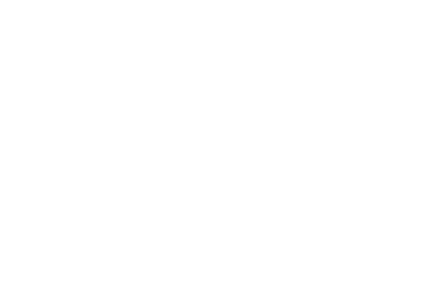

In [64]:
ta = timer()
m1 = solve_bnp(N, edges)
tb = timer()

print(m1.numCols)

cols = all_ind_set(N, edges)

print(len(cols))

tc = timer()
m2 = solve_MIP(N, edges, cols)
td = timer()

tb-ta, tc-tb, td-tc


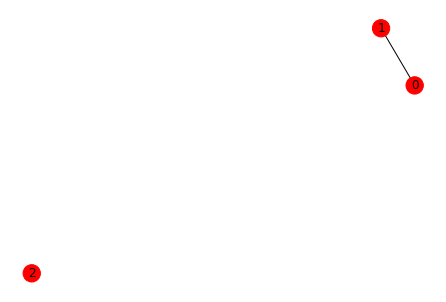

In [65]:
for node in m1.nodes:
    if node.status == NodeStatus.GLOBAL_OPT:
        plot_sol(N, edges, sol=node.solution, helper=GCPHelper((N, edges)))

In [23]:
# for x in range(1000):
#     N = 10
#     M = int(N*N * 0.25)
#     edges = set() 
#     for i in range(M):
#         a = random.randint(0, N-1)
#         b = random.randint(0, N-1)
#         if a == b:
#             continue
#         edges.add((min(a, b), max(a, b)))
#     gcpBnP = BnP(name="GCP", data=(N, edges), modelClass=GurobiModel, modelSense=GRB.MINIMIZE,
#                 masterClass=GCPMaster, pricingClass=GCPPricing, helperClass=GCPHelper,
#                 muteColGened=True, muteBranchBegin=True, muteBranchSolved=True, muteNewBranchAdded=True)
#     gcpBnP.branchAndPrice()
   
    